In [324]:
from utils import *
import array 

from pydub import AudioSegment
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical

from keras.layers import Input, GRU, RepeatVector, BatchNormalization, TimeDistributed, Conv1D
from keras import backend as K
from keras.layers import  Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape


from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numba

import dask.dataframe as dd
from dask.multiprocessing import get

%matplotlib inline

In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

In [343]:
%%time 

# train_df = pickle.load( open("cache/train_df.pik","rb"))
# valid_df = pickle.load( open("cache/valid_df.pik","rb"))
silent_df = pickle.load(open("cache/silent_df.pik","rb"))
# unknown_df = pickle.load(open("cache/unknown_df.pik","rb"))
# test_df =  pickle.load(open("cache/test_df.pik","rb"))

CPU times: user 200 ms, sys: 52 ms, total: 252 ms
Wall time: 248 ms


In [24]:
filler = AudioSegment.silent(duration=1000, frame_rate = 16000)
silence_files_AS = [AudioSegment.from_wav(x) for x in silent_df.wav_file.values]

In [335]:
def fill_to_1sec(wav):
    #fill to 1 second
    L = 1000 #16000  # 1 sec
    sample_rate = 16000
    
    if len(wav) > L:
        i = np.random.randint(0, len(wav) - L)
        wav = wav[i:(i+L)]
    elif len(wav) < L:
        rem_len = L - len(wav)
        wav = AudioSegment.silent(rem_len,frame_rate=sample_rate) + wav
        
    return wav    

def augment_wav(wav,pval=0.5):
    sample_rate = 16000
    L = 1000 #16000  # 1 sec
    
    #adjust speed, with 50% chance
#     wav = speed_change(wav,1.+random.uniform(-1, 1)*0.05) if np.random.random() < pval else wav
    
    
    #adjust volume
    db_adjustment = random.uniform(-1, 1)*10
    wav = wav + db_adjustment if np.random.random() < pval else wav
     
        
    #fill to 1 second
    wav = fill_to_1sec(wav)        
        
    #shift the audio by 10 ms
    shift_length = 100
    if np.random.random() < 0.5: #shift to left
        wav = wav[:L-shift_length]+ AudioSegment.silent(shift_length,frame_rate=sample_rate)
    else: #shift to right
        wav = AudioSegment.silent(shift_length,frame_rate=sample_rate) + wav[shift_length:]
        
        
        
    #blend original file with background noise     
    if np.random.random() < pval:
        noise = random.choice(silence_files_AS)
        db_delta = (wav.dBFS - noise.dBFS) -10.

        if db_delta< 0: #reduce intensity of loud background; if it's too silent, leave it be
            noise = noise  + db_delta
        wav = wav.overlay(noise)
 
    return wav


def AS_to_raw(as_file):
	wav = np.array(as_file.get_array_of_samples().tolist())      
#     wav = wav.astype(np.float32) / np.iinfo(np.int16).max
	return wav   


AS_to_raw = numba.jit(AS_to_raw)


def process_wav_file(record, reshape=False, augment=True,pval=0.5 ,output_format='logmel'):
    
    if type(record) == str: # test files
        fname = record
        label = "test"
    else:    
        fname  = record.wav_file
        label = record.label

        
        
        
        
    if "raw_AS_wav" in record: 
        wav = record.raw_AS_wav
    else:
        wav = AudioSegment.from_wav(fname)
        
        
    
    if (not label in ["silence"]) and augment: #no augmentation for sample files 
        wav = augment_wav(wav,pval)

    else: #make sure segment is 1 second
        wav = fill_to_1sec(wav)

        
    samples = AS_to_raw(wav)
    
    
    
    if output_format == "logmel":
        output = log_mel(samples,reshape=reshape)
    else:
        output = samples
    
    
    return output


In [336]:
#precomputing augs for faster neural net training
def precompute_augmentations(df,num_repeats=4):
    
    df_aug= pd.concat([df]*num_repeats)
    df_aug['raw'] = df_aug.wav_file.apply(process_wav_file)
    df = pd.concat([df, df_aug])
    
    return df 


In [340]:
%time unknown_df = precompute_augmentations(unknown_df)

CPU times: user 28min 15s, sys: 28.8 s, total: 28min 44s
Wall time: 14min 16s


In [342]:

pickle.dump( train_df,open("cache/train_df_waug.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(unknown_df, open("cache/unknown_df_waug.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)

In [309]:
#profiling: it's too costly to do augmentation on the fly with low gpu utilization; 
# could be explained by the small gpu-cost vs cpu-preprocessing: gpu batches finish much sooner than cpu is done with augmentation
# it's not fully due to reading from disk, but mostly about manipulation the wav file
%time w = AudioSegment.from_wav(train_df.wav_file.iloc[0])
# %time w = load_audio_file(train_df.wav_file.iloc[0])
# wn = np.random.randn(len(w))
# %time w = w + 0.005*wn

%time ww = train_df.loc[0,"raw_AS_wav"]
%time ww = AS_to_raw(w)
%time ww = AS_to_raw_fast(w)

# %time w = augment_wav(w)
# %time ww =  AS_to_raw(w)
# %time w = w.get_array_of_samples()



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 472 µs
CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 4.14 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.29 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.12 ms


In [66]:
%%time

# %time train_df['raw_AS_wav'] = train_df.wav_file.apply(lambda fname: AudioSegment.from_wav(fname))

# %time valid_df["raw_AS_wav"]  = valid_df.wav_file.apply(lambda fname: AudioSegment.from_wav(fname))

# %time silent_df["raw_AS_wav"]  = silent_df.wav_file.apply(lambda fname: AudioSegment.from_wav(fname))

# %time unknown_df["raw_AS_wav"]   = unknown_df.wav_file.apply(lambda fname: AudioSegment.from_wav(fname))


# pickle.dump( train_df,open("cache/train_df.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)
# pickle.dump(valid_df, open("cache/valid_df.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)
# pickle.dump(silent_df, open("cache/silent_df.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)
# pickle.dump(unknown_df, open("cache/unknown_df.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


In [350]:
#no augmentation since the auto encoder has already seen all the train AND test files 

def train_generator(train_batch_size):
    while True:
        
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))
        extra_data_size = int(this_train.shape[0]* 0.1)
        this_train = pd.concat([silent_df.sample(extra_data_size),
                                this_train,
                                unknown_df.sample(extra_data_size*4)],axis=0 )
        
        this_train.reset_index(drop=True,inplace=True)
        
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            y_batch = []
            
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
                x_batch.append(this_train.loc[i,'raw'].T)
#                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)

                y_batch.append(this_train.label_id.values[i])
                
            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            
            yield x_batch, y_batch

In [355]:
%time t = next(train_generator(256))[0][0].T

CPU times: user 84 ms, sys: 0 ns, total: 84 ms
Wall time: 80.2 ms


In [205]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(valid_df.loc[i,'raw'].T)
                y_batch.append(valid_df.label_id.values[i])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [380]:
from keras.callbacks import TensorBoard
exp_name = "aebase_aug_drp3_frozen"
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min'),
             
            TensorBoard(log_dir='./logs/logs_{}'.format(exp_name), histogram_freq=0, batch_size=64, write_graph=True)]

In [92]:
#a common practice is to choose a filter size in time which spans 2/3 o

In [364]:
timesteps, input_dim , latent_dim = 32,128, 128

input_img = Input(shape=(timesteps, input_dim))  # adapt this if using `channels_first` image data format

x = Reshape((timesteps, input_dim,1))(input_img)

x = Conv2D(64, (10, 10), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same',name='latent_rep')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (10, 10), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoded  = Reshape((timesteps, input_dim))(decoded)

autoencoder = Model(input_img, decoded)

In [47]:
autoencoder.load_weights("./weights/starter_ae_wtest_conv_rmse_c6.hdf5")

In [48]:
for l in autoencoder.layers:
    l.trainable = False

In [49]:
autoencoder.get_layer("latent_rep").output_shape

(None, 4, 16, 32)

In [50]:
p = 0.3

x = Conv2D(64, (1, 1), activation='relu', padding='same')(autoencoder.get_layer("latent_rep").output)

x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
x = Dropout(p/2)(x)
x = BatchNormalization()(x)

x = MaxPooling2D((2,2),padding='same')(x)

x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
x = Dropout(p/2)(x)

x = GlobalMaxPool2D()(x)

x = Dense(128, activation = 'relu')(x)
x = Dropout(p)(x)

x = Dense(len(POSSIBLE_LABELS), activation = 'softmax', name='targets')(x)


In [51]:

model = Model(inputs=[input_img], outputs = x)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 128)           0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 128, 64)       6464      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 64, 32)        51232     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 32, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 32)         9248      
__________

In [101]:
# p = 0.5

# x_in = Input(shape = (128,32,1)) #1 channel, 99 time, 161 freqs # S : np.ndarray [shape=(n_mels, t)]

# x = BatchNormalization()(x_in)

# x = Conv2D(64, (9,10),activation='relu',padding='same')(x)
# x = Dropout(p)(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((3,2),padding='same')(x)

# x = Conv2D(128, (4,5),activation='relu',padding='same')(x)
# x = Dropout(p)(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((3,2),padding='same')(x)


# x = Conv2D(128, (2,2),activation='relu',padding='same')(x)
# x = Dropout(p)(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(padding='same')(x)



# x = GlobalMaxPool2D()(x)

# # x = Flatten()(x)
# x = Dense(64, activation = 'relu')(x) #
# x = Dropout(p)(x)

# # x = Dense(64, activation = 'relu')(x)
# # x = Dropout(0.3)(x)

# x = Dense(len(POSSIBLE_LABELS), activation = 'softmax', name='targets')(x)




# model = Model(inputs = x_in, outputs = x)
# model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
# # model.summary()

In [58]:
train_df.head()

,label,label_id,user_id,wav_file,raw,raw_AS_wav
0,left,4,cb8f8307,./data/train/audio/left/cb8f8307_nohash_1.wav,"[[-80.0, -80.0, -53.5190041125, -45.8180520192...",(((<pydub.audio_segment.AudioSegment object at...
1,left,4,b7a0754f,./data/train/audio/left/b7a0754f_nohash_2.wav,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",(((<pydub.audio_segment.AudioSegment object at...
2,left,4,0132a06d,./data/train/audio/left/0132a06d_nohash_3.wav,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",(((<pydub.audio_segment.AudioSegment object at...
3,left,4,f92e49f3,./data/train/audio/left/f92e49f3_nohash_4.wav,"[[-80.0, -80.0, -80.0, -79.1795468386, -61.342...",(((<pydub.audio_segment.AudioSegment object at...
4,left,4,88053e92,./data/train/audio/left/88053e92_nohash_1.wav,"[[-80.0, -80.0, -80.0, -74.5488604542, -75.231...",(((<pydub.audio_segment.AudioSegment object at...


Epoch 14/100
300/300 [==============================] - 214s - loss: 0.7612 - acc: 0.7370 - val_loss: 1.0481 - val_acc: 0.6508



Epoch 31/100
350/350 [==============================] - 227s - loss: 0.4294 - acc: 0.8518 - val_loss: 0.9436 - val_acc: 0.7179
Epoch 32/100



Epoch 00058: reducing learning rate to 1.00000006569e-06.
329/329 [==============================] - 191s - loss: 0.7292 - acc: 0.7521 - val_loss: 0.7132 - val_acc: 0.8770


with ae, p=0.
Epoch 28/100
329/329 [==============================] - 7s - loss: 0.3312 - acc: 0.8829 - val_loss: 0.4124 - val_acc: 0.8579

with p=0.4 and /2 for convs 
Epoch 28/100
329/329 [==============================] - 7s - loss: 0.5534 - acc: 0.8056 - val_loss: 0.5074 - val_acc: 0.8312

with p=0.2 and /2
Epoch 00035: reducing learning rate to 1.0000000475e-05.
329/329 [==============================] - 7s - loss: 0.2414 - acc: 0.9137 - val_loss: 0.3686 - val_acc: 0.8811

In [56]:
train_df.shape[0]*(1.2)//64

395.71875

In [356]:
batch_size = 128

history = model.fit_generator(generator=train_generator(batch_size),
                              steps_per_epoch=train_df.shape[0]*(1.2)//batch_size,
                              epochs=100,
                              callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)))

Epoch 1/100
989/989 [==============================] - 36s - loss: 0.9326 - acc: 0.6730 - val_loss: 0.7046 - val_acc: 0.7614
Epoch 2/100
989/989 [==============================] - 36s - loss: 0.8052 - acc: 0.7186 - val_loss: 0.6923 - val_acc: 0.7546
Epoch 3/100
989/989 [==============================] - 36s - loss: 0.7264 - acc: 0.7456 - val_loss: 0.5195 - val_acc: 0.8225
Epoch 4/100
989/989 [==============================] - 37s - loss: 0.6787 - acc: 0.7629 - val_loss: 0.5026 - val_acc: 0.8255
Epoch 5/100
989/989 [==============================] - 37s - loss: 0.6375 - acc: 0.7777 - val_loss: 0.4492 - val_acc: 0.8552
Epoch 6/100
989/989 [==============================] - 36s - loss: 0.6040 - acc: 0.7901 - val_loss: 0.4668 - val_acc: 0.8383
Epoch 7/100
989/989 [==============================] - 37s - loss: 0.5798 - acc: 0.7983 - val_loss: 0.4556 - val_acc: 0.8407
Epoch 8/100
989/989 [==============================] - 37s - loss: 0.5590 - acc: 0.8046 - val_loss: 0.4429 - val_acc: 0.8529


In [379]:
for l in model.layers:
    l.trainable = True
    
    
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [381]:
model.load_weights('./weights/{}.hdf5'.format(exp_name))

In [383]:
exp_name = "aebase_aug_drp3_finetune"
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-6),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True)]

In [384]:
history = model.fit_generator(generator=train_generator(batch_size),
                              steps_per_epoch=train_df.shape[0]*(1.2)//batch_size,
                              epochs=100,
                              callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)))

Epoch 1/100
989/989 [==============================] - 85s - loss: 0.4034 - acc: 0.8585 - val_loss: 0.3539 - val_acc: 0.8835
Epoch 2/100
989/989 [==============================] - 85s - loss: 0.3916 - acc: 0.8625 - val_loss: 0.3505 - val_acc: 0.8849
Epoch 3/100
989/989 [==============================] - 85s - loss: 0.3909 - acc: 0.8629 - val_loss: 0.3477 - val_acc: 0.8822
Epoch 4/100
989/989 [==============================] - 85s - loss: 0.3857 - acc: 0.8651 - val_loss: 0.3477 - val_acc: 0.8819
Epoch 5/100
989/989 [==============================] - 85s - loss: 0.3845 - acc: 0.8654 - val_loss: 0.3238 - val_acc: 0.8920
Epoch 6/100
989/989 [==============================] - 85s - loss: 0.3817 - acc: 0.8664 - val_loss: 0.3444 - val_acc: 0.8822
Epoch 7/100
989/989 [==============================] - 85s - loss: 0.3786 - acc: 0.8676 - val_loss: 0.3361 - val_acc: 0.8883
Epoch 8/100
989/989 [==============================] - 85s - loss: 0.3751 - acc: 0.8679 - val_loss: 0.3391 - val_acc: 0.8903


In [385]:
model.load_weights('./weights/{}.hdf5'.format(exp_name))

### valid evaluation

In [386]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [387]:
val_preds = model.predict_generator(valid_generator(64),steps=int(np.ceil(valid_df.shape[0]/64.)))
val_preds = np.argmax(val_preds,axis=1)

In [31]:
val_preds.shape

(3091, 12)

In [388]:
oe = OneHotEncoder()

In [389]:
y_true = oe.fit_transform(valid_df.label_id.values.reshape(-1, 1)).todense()



In [390]:
val_preds = oe.transform(val_preds.reshape(-1, 1)).todense()


In [391]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.95      0.94      0.95       261
         no       0.82      0.85      0.84       270
         up       0.89      0.91      0.90       260
       down       0.92      0.88      0.90       264
       left       0.92      0.90      0.91       247
      right       0.97      0.86      0.91       256
         on       0.96      0.86      0.91       257
        off       0.92      0.88      0.90       256
       stop       0.96      0.87      0.91       246
         go       0.86      0.76      0.81       260
    silence       0.98      0.99      0.98       257
    unknown       0.62      0.92      0.74       257

avg / total       0.90      0.89      0.89      3091



In [56]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.93      0.95      0.94       261
         no       0.84      0.81      0.82       270
         up       0.88      0.90      0.89       260
       down       0.83      0.91      0.87       264
       left       0.92      0.88      0.90       247
      right       0.93      0.89      0.91       256
         on       0.89      0.89      0.89       257
        off       0.93      0.86      0.89       256
       stop       0.89      0.89      0.89       246
         go       0.81      0.78      0.79       260
    silence       1.00      1.00      1.00       257
    unknown       0.71      0.78      0.74       257

avg / total       0.88      0.88      0.88      3091



### submission


In [395]:
test_paths = glob(os.path.join('./data/', 'test/audio/*wav'))

In [396]:
len(test_paths)

158538

In [392]:
test_df = pickle.load( open("cache/test_df.pik","rb"))


In [397]:
def test_generator(test_batch_size,augment=False):
    while True:
        ids = list(range(test_df.shape[0]))
        
        for start in range(0, len(ids), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(ids))
            i_test_batch = ids[start:end]
#             this_paths = test_paths[start:end]
#             for x in this_paths:
            for i in i_test_batch:
            #WATCHOUT > NO AUG
#                 x_batch.append(process_wav_file(x).T) #,reshape=False,augment=augment,pval=0.5))
                x_batch.append(test_df.loc[i,'raw'].T)

            x_batch = np.array(x_batch)
            x_batch = 1.- np.array(x_batch)/-80.
            
            yield x_batch

In [ ]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(valid_df.loc[i,'raw'].T)
                y_batch.append(valid_df.label_id.values[i])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [398]:
predictions = model.predict_generator(test_generator(256,augment=False), int(np.ceil(len(test_paths)/256.)), verbose=1)

620/620 [==============================] - 34s    


In [399]:
np.save("cache/predictions_{}.npy".format(exp_name),predictions)

In [400]:
predictions.shape

(158538, 12)

#### blending

In [407]:
predictions_pyramid_noaug = np.load('cache/predictions_pyramid_noaug.npy')
predictions_model_with_ae_base_drp2_1 = np.load('cache/predictions_model_with_ae_base_drp2_1.npy')

In [408]:
predictions = np.mean([predictions,predictions_pyramid_noaug,predictions_model_with_ae_base_drp2_1], axis=0)


In [156]:
# num_aug = 2 
# for i in range(num_aug):
#     predictions +=  model.predict_generator(test_generator(64,augment=True), int(np.ceil(len(test_paths)/64.)), verbose=1)
    

# predictions = predictions/(num_aug + 1.0)

2477/2478 [============================>.] - ETA: 0s

#### class assignment

In [409]:
classes = np.argmax(predictions, axis=1)

In [410]:
classes.shape, len(test_paths)

((158538,), 158538)

(array([ 12769.,   6288.,   7058.,   6322.,   6488.,   7524.,   5727.,
          6044.,   7517.,  92801.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

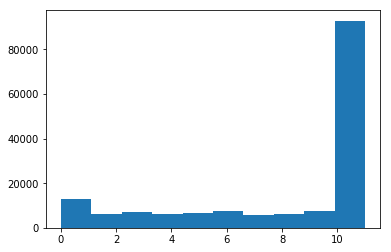

In [411]:
plt.hist(classes,bins=10)

(array([ 12482.,   6260.,   6059.,   6403.,   5591.,   7249.,   6102.,
          6070.,   7064.,  95258.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

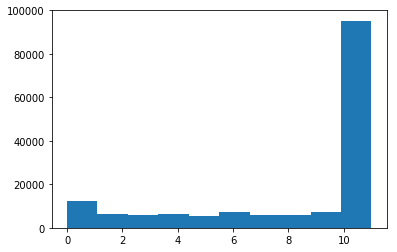

In [403]:
plt.hist(classes,bins=10)

(array([ 13909.,   6442.,  10015.,   6507.,   8567.,   8867.,   5738.,
          6198.,   9714.,  82581.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

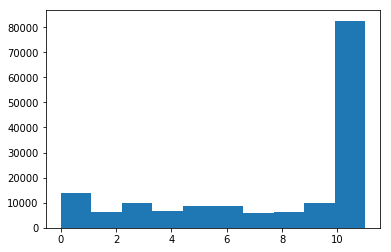

In [69]:
plt.hist(classes,bins=10)

(array([ 14037.,   7124.,  12571.,   6486.,  10360.,  11502.,   6549.,
          6624.,  10275.,  73010.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

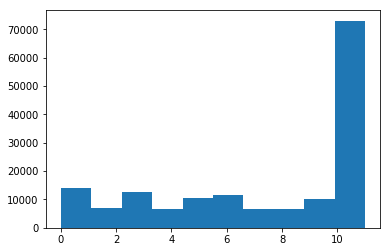

In [122]:
plt.hist(classes,bins=10)

### blending

### submission

In [412]:
### last batch will contain padding, so remove duplicates
submission = dict()
for i in range(len(test_paths)):
    fname, label = os.path.basename(test_paths[i]), id2name[classes[i]]
    submission[fname] = label

In [413]:
with open('subm/submission_{}.csv'.format(exp_name), 'w') as fout:
    fout.write('fname,label\n')
    for fname, label in submission.items():
        fout.write('{},{}\n'.format(fname, label))

In [414]:
from IPython.lib.display import FileLink

FileLink('subm/submission_{}.csv'.format(exp_name))


/home/ubuntu/keyword_spotting/subm/submission_aebase_aug_drp3_finetune_blend.csv